# Chapter 3: LIME for Transformers

| Chapter  | Colab   | Kaggle          | Gradient      | Studio Lab             |
|:---------|:--------|:----------------|:--------------|:-----------------------|
| [Chapter 3: LIME for Transformers](3_model_explainability_and_interpretability/Chapter_3_LIME_for_Transformers.ipynb)                          | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matthew-mcateer/practicing_trustworthy_machine_learning/blob/main/3_model_explainability_and_interpretability/Chapter_3_LIME_for_Transformers.ipynb)        | [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/blob/main/3_model_explainability_and_interpretability/Chapter_3_LIME_for_Transformers.ipynb)        | [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/matthew-mcateer/practicing_trustworthy_machine_learning/blob/main/3_model_explainability_and_interpretability/Chapter_3_LIME_for_Transformers.ipynb)        | [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/matthew-mcateer/practicing_trustworthy_machine_learning/blob/main/3_model_explainability_and_interpretability/Chapter_3_LIME_for_Transformers.ipynb)        |


In [1]:
#@title Installing dependencies { display-mode: "form" }
!pip -qq install lime transformers watermark torch torchvision
%load_ext watermark
%watermark -a "Practicing Trustworthy machine Learning" -u -d -v -m -p lime,transformers,torch,torchvision,numpy
!nvidia-smi

     |████████████████████████████████| 275 kB 26.4 MB/s 
     |████████████████████████████████| 5.5 MB 53.1 MB/s 
     |████████████████████████████████| 7.6 MB 49.2 MB/s 
     |████████████████████████████████| 182 kB 60.7 MB/s 
     |████████████████████████████████| 1.6 MB 60.5 MB/s 
Author: Practicing Trustworthy machine Learning

Last updated: 2022-11-27

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

lime        : 0.2.0.1
transformers: 4.24.0
torch       : 1.12.1+cu113
torchvision : 0.13.1+cu113
numpy       : 1.21.6

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.10.133+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Sun Nov 27 10:59:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU 

## Text

In [2]:
import numpy as np

import torch
import torch.nn.functional as F

from lime.lime_text import LimeTextExplainer
from pprint import pprint
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
class_names = ["positive", "negative", "neutral"]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [3]:
def predictor(texts):
    outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
    probas = F.softmax(outputs.logits).detach().numpy()
    pprint(probas.shape)
    return probas

In [4]:
#@title LIME Text Explainer

explainer = LimeTextExplainer(class_names=class_names)
str_to_predict = (
    f"alarming decrease in market share despite increases "
    f"in revenue and decreased operating costs"
)
exp = explainer.explain_instance(
    str_to_predict, predictor, num_features=20, num_samples=2000
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


(2000, 3)


In [5]:
exp.show_in_notebook(text=str_to_predict)

## Images

In [6]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification
from transformers import ViTFeatureExtractor

%config InlineBackend.figure_format = 'retina'

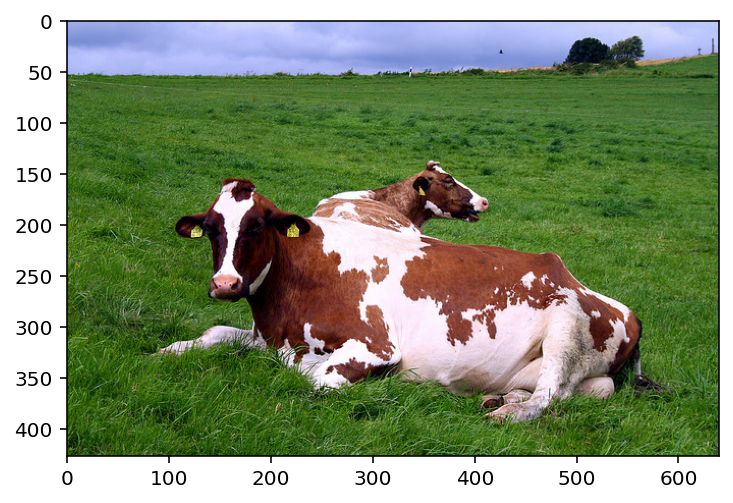

In [7]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url = 'http://images.cocodataset.org/test-stuff2017/000000000019.jpg'
img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
plt.imshow(img);

In [8]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224"
)
feature_extractor = ViTFeatureExtractor.from_pretrained(
    "google/vit-base-patch16-224"
)


Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [9]:
def get_pil_transform():
    transf = transforms.Compose(
        [transforms.Resize((256, 256)), transforms.CenterCrop(224)]
    )

    return transf


def get_preprocess_transform():
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    transf = transforms.Compose([transforms.ToTensor(), normalize])
    return transf


pil_transf = get_pil_transform()


def numpy_to_pil(numpy_array):
    if len(numpy_array.shape) == 3:
        return Image.fromarray(numpy_array)
    elif len(numpy_array.shape) == 4:
        pil_list = []
        for i in range(numpy_array.shape[0]):
            pil_list.append(Image.fromarray(numpy_array[i]))
        return pil_list
    else:
        raise ValueError(
            "The numpy array must be 3-dimensional or 4-dimensional"
        )


def batch_predict(input_images: np.ndarray):
    pil_images = numpy_to_pil(input_images)
    model.eval()
    batch = feature_extractor(images=pil_images, return_tensors="pt")
    batch = batch["pixel_values"]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    output = model(batch)
    probs = F.softmax(output.logits, dim=1)
    return probs.detach().cpu().numpy()

In [10]:
from lime import lime_image

# Hide color is the color for a superpixel turned OFF. Alternatively,
# if it is NONE, the superpixel will be replaced by the average of its pixels
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(pil_transf(img)),
    # classification function
    batch_predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000,
)
# number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's use mask on image and see the areas that are encouraging the top prediction.

In [12]:
explanation.top_labels

[345, 690, 346, 984, 730]

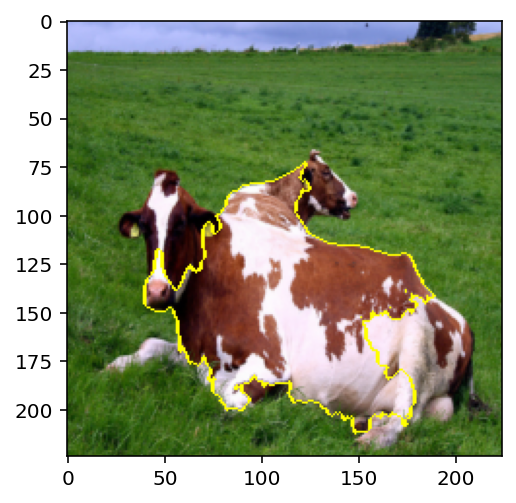

In [13]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False,
)
img_boundary_1 = mark_boundaries(temp / 255.0, mask)
plt.imshow(img_boundary_1);

Let's turn on areas that contributes against the top prediction.

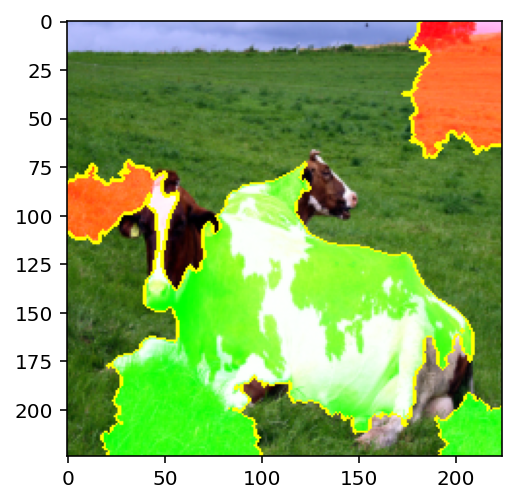

In [14]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False,
)
img_boundary_2 = mark_boundaries(temp / 255.0, mask)
plt.imshow(img_boundary_2);

## References and Resources

1.   [Is there any tutorial on how to apply Lime to BERT? - marcotcr/lime Issues #356](https://github.com/marcotcr/lime/issues/356)
2.   [Li, S. (2019, July 4). Explain NLP models with Lime &amp; Shap. Medium. Retrieved November 27, 2022, from https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b ](https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b)
3.   [Cloudera. (2020, June 20). How to explain huggingface bert for question answering NLP models with TF&nbsp;2.0. Cloudera Fast Forward Blog. Retrieved November 27, 2022, from https://blog.fastforwardlabs.com/2020/06/22/how-to-explain-huggingface-bert-for-question-answering-nlp-models-with-tf-2.0.html ](https://blog.fastforwardlabs.com/2020/06/22/how-to-explain-huggingface-bert-for-question-answering-nlp-models-with-tf-2.0.html)
4.   [Github marcotcr/lime - Tutorial - images - PyTorch](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb)
5.   [Github NielsRogge/Transformers-Tutorials - Quick demo of HuggingFace version of Vision Transformer](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Quick_demo_of_HuggingFace_version_of_Vision_Transformer_inference.ipynb)
6.   [Marco Tulio Correia Ribeiro. (n.d.). Create a predict fn for inception v3, takes in a list of images and returns a matrix of prediction probabilities. Lime Images. Retrieved November 27, 2022, from https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html ](https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html)

